#Image Classification Fastai V1



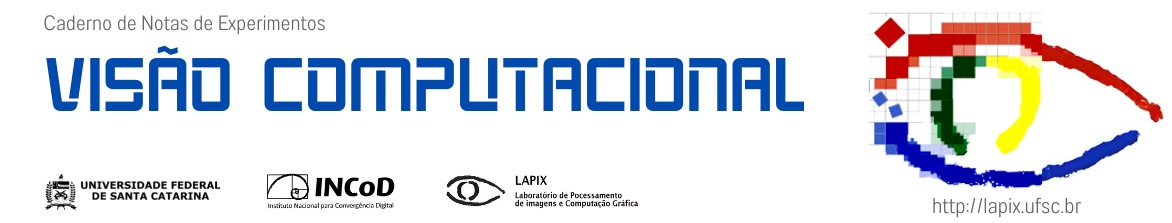

# Autores:


* Aldo Von Wangenheim: aldo.vw@ufsc.br
* Thiago Zimmermann Loureiro Chaves: thiago.zlc@grad.ufsc.br





# Para utilizar a placa de vídeo no Google Colab...

1) clique no ▾ do lado de "Conectar"

2) Ver recursos

3) Alterar o tipo de ambiente de execução

4) Acelerador de hardware: GPU

5) Execute a célula abaixo. Ela deve retornar as informações da placa de vídeo.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Mon Apr 10 04:37:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Instalando Fastai e Pytorch

In [ ]:
!pip install fastai wandb timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=53680a3c33ce52bd56a5b32176b619f29edf513d2616318fa35238684e6e14af
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *
import timm

In [ ]:
wandb.login(key='YOUR_KEY')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#Monta seu Drive no Notebook

In [ ]:
import os

# Codigo para montar o Google Drive
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Transforms


In [ ]:
def get_dls(path, bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                       item_tfms=Resize(size),
                       batch_tfms=aug_transforms())

    return dblock.dataloaders(path, bs=bs)

In [ ]:
path = Path('/content/gdrive/Shareddrives/MindFunga/SplittedProtax28-03/Esporos1000x')
dls = get_dls(path, bs=8, size=224)

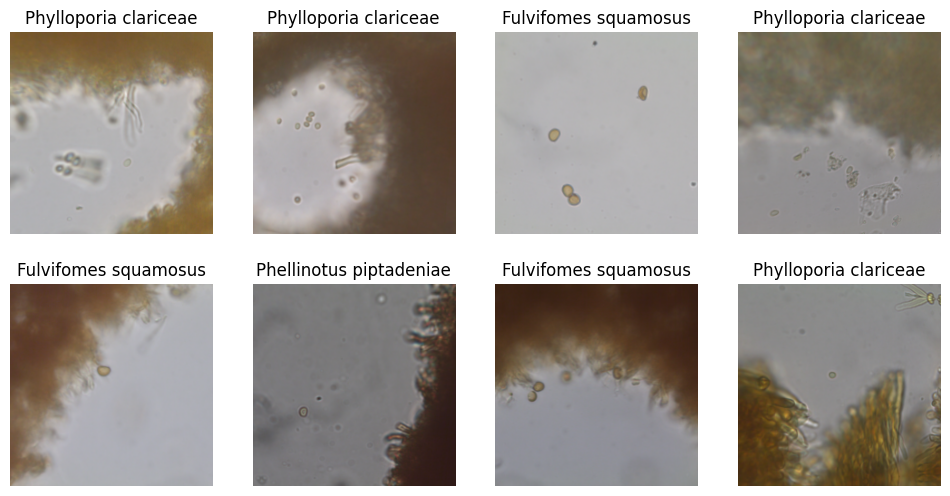

In [ ]:
dls.show_batch()


#Selecionamos a Rede Neural


*   Hrnet18, Hrnet32
*   VIT_base_patch, VIT_small_patch

Para mais modelos:
https://github.com/huggingface/pytorch-image-models/tree/main/timm/models


In [ ]:
def hrnet18(pretrained=True):
    model = timm.create_model("hrnet_w18_small_v2", pretrained=pretrained)
    return model

def hrnet32(pretrained=True):
    model = timm.create_model("hrnet_w32", pretrained=pretrained)
    return model

def vit_base_patch16_224(num_classes=3, pretrained=True):
    model = timm.create_model("vit_base_patch16_224", pretrained=pretrained, num_classes=num_classes)
    return model

def vit_small_patch16_224(num_classes=3, pretrained=True):
    model = timm.create_model("vit_small_patch16_224", pretrained=pretrained, num_classes=num_classes)
    return model

model = vit_small_patch16_224(pretrained=True)

In [ ]:
wandb.init(project='Tcc_Esporos1000x_Abril_3classes')

In [ ]:
# Create model with pre-trained weights
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=WandbCallback(log_preds=False, log_model=False))

In [ ]:
test_dl = dls.test_dl(get_image_files(path/'test'))

In [ ]:
learn.fine_tune(15)

In [ ]:
preds, targets = learn.get_preds(dl=test_dl)

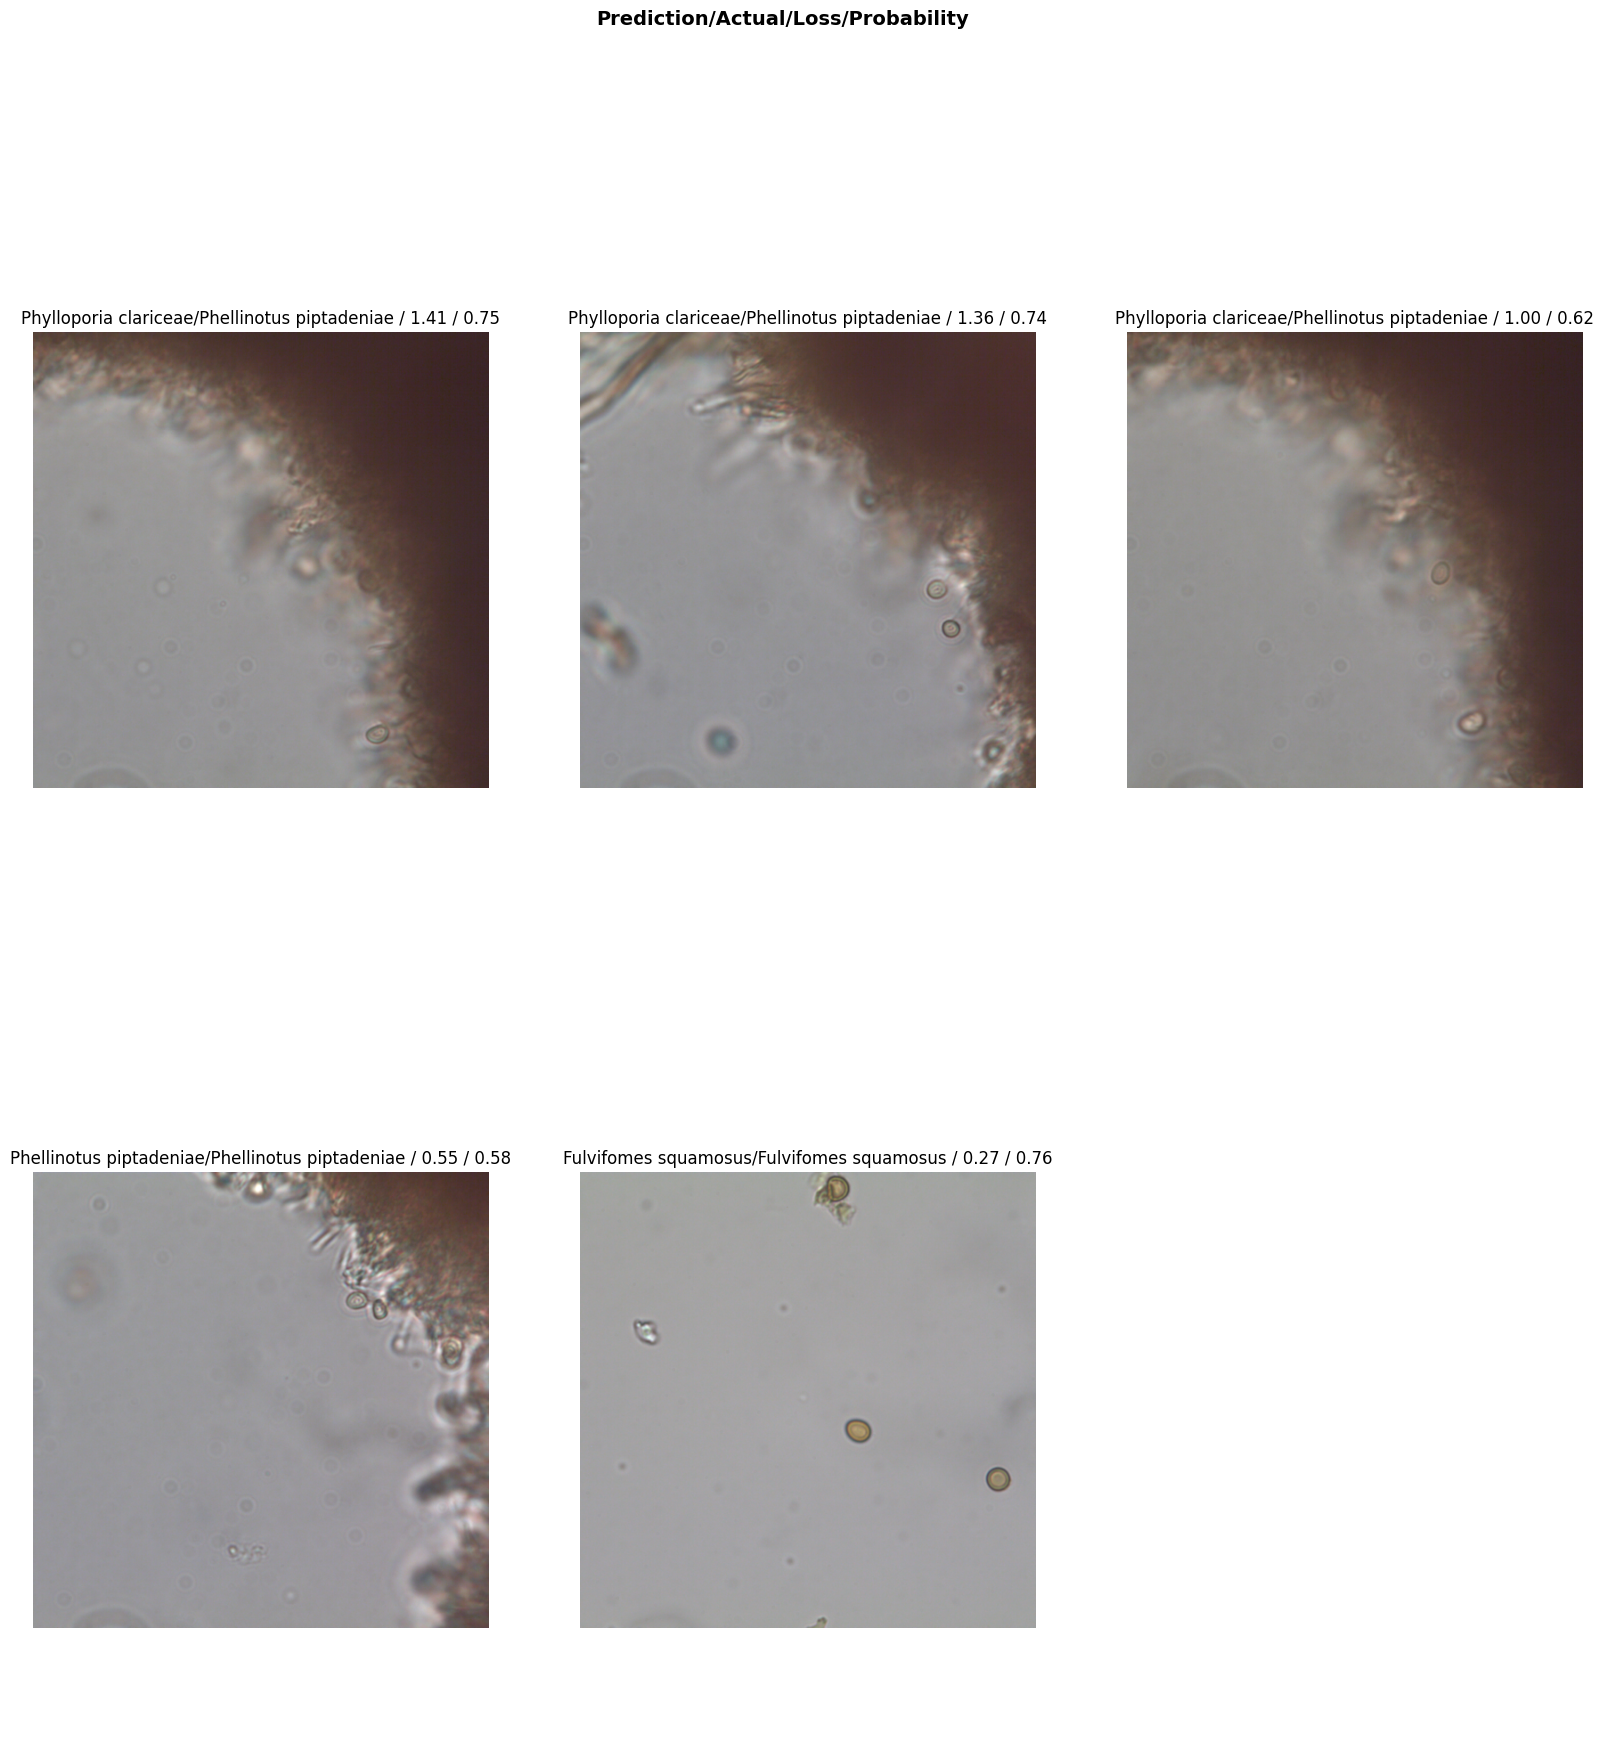

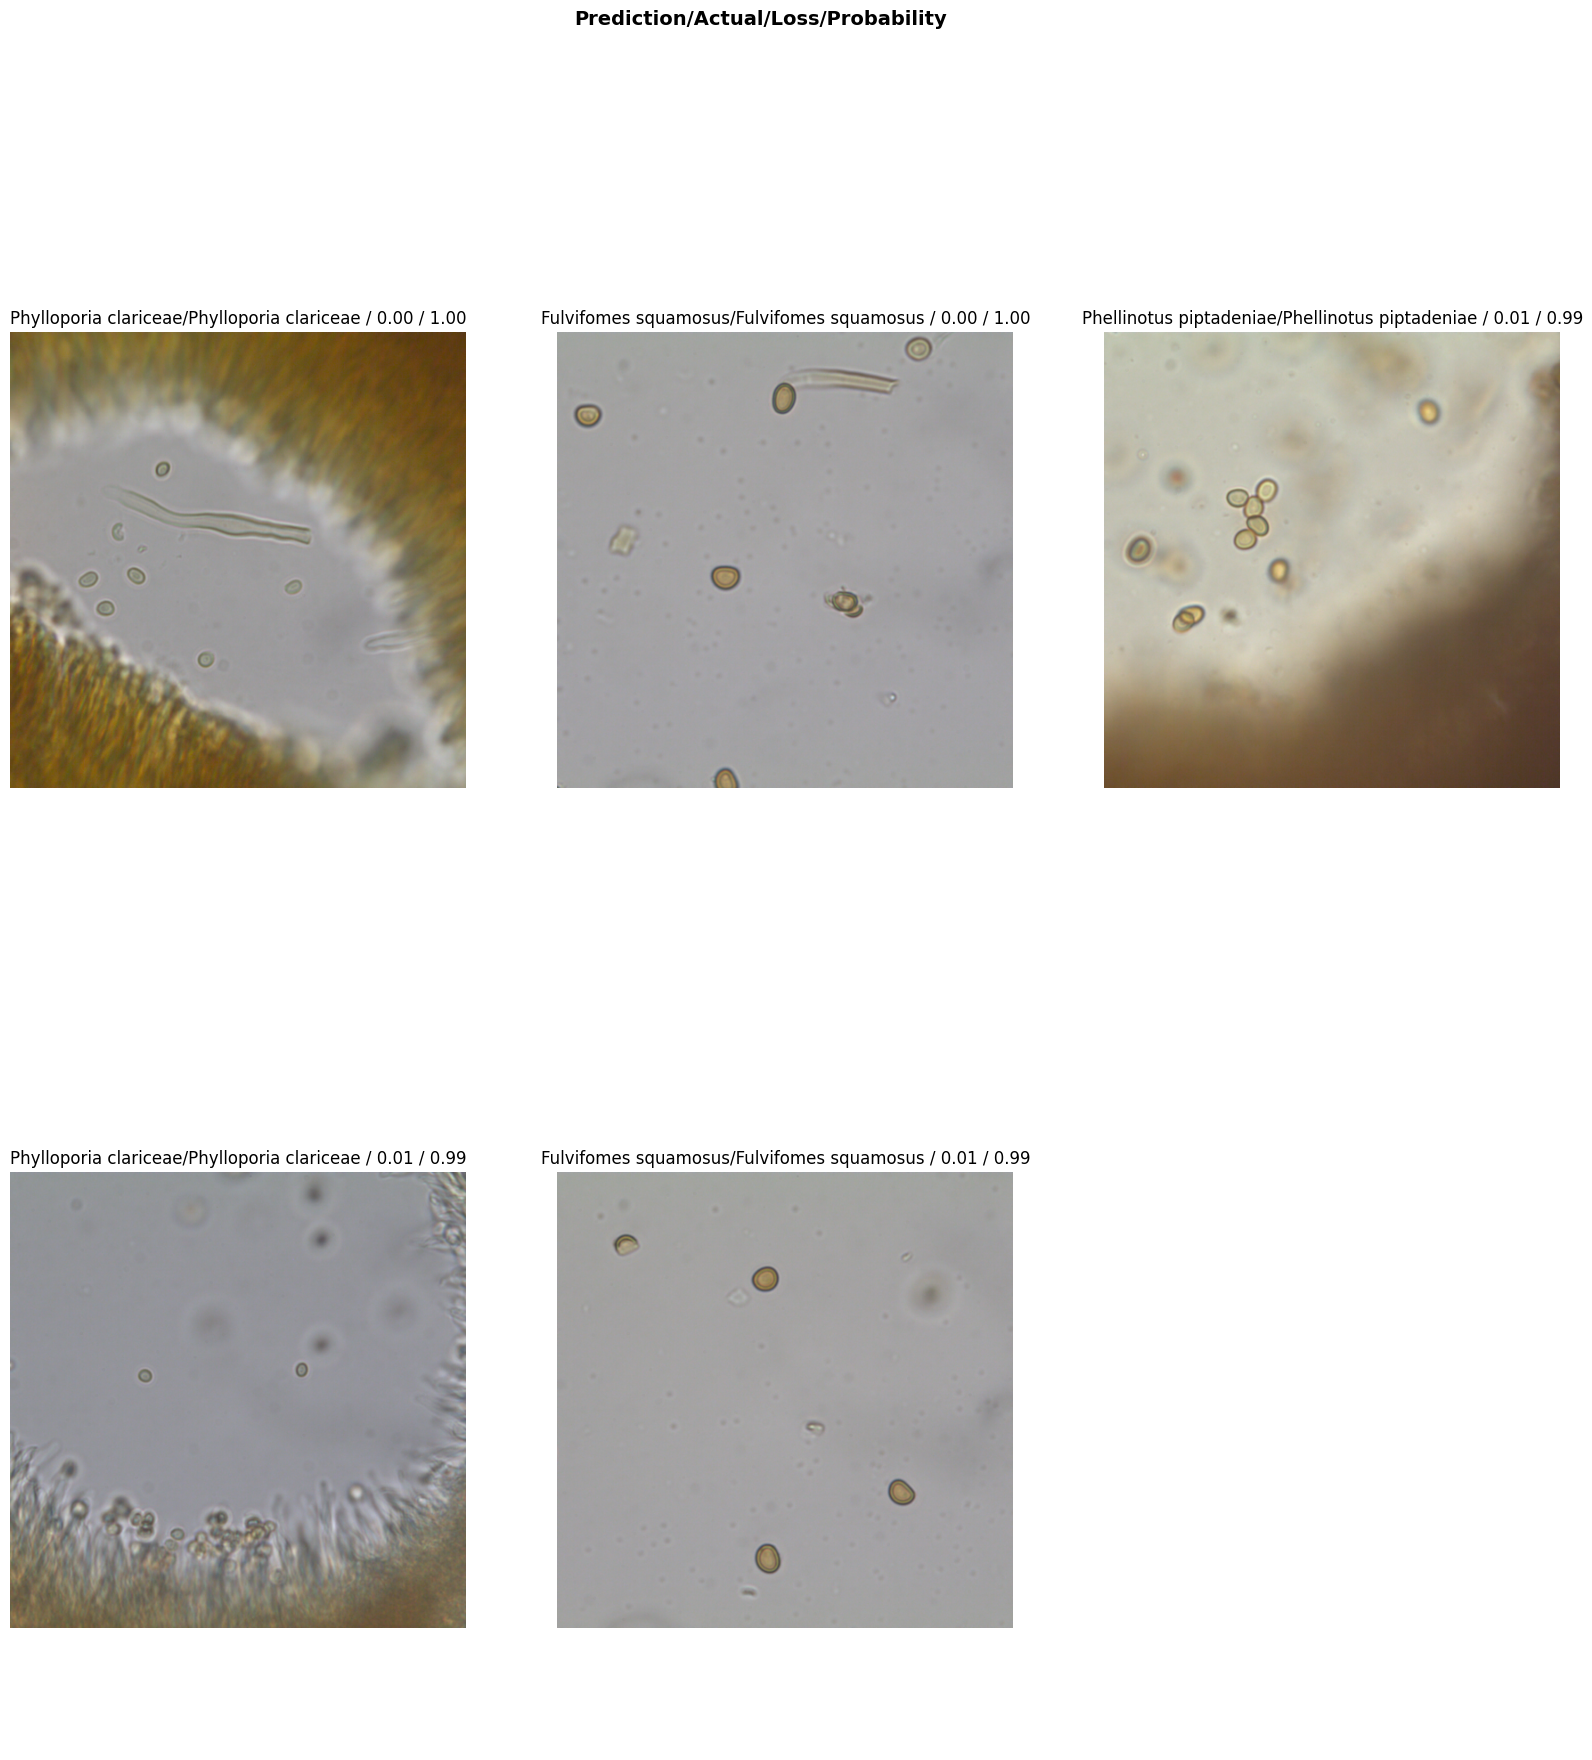

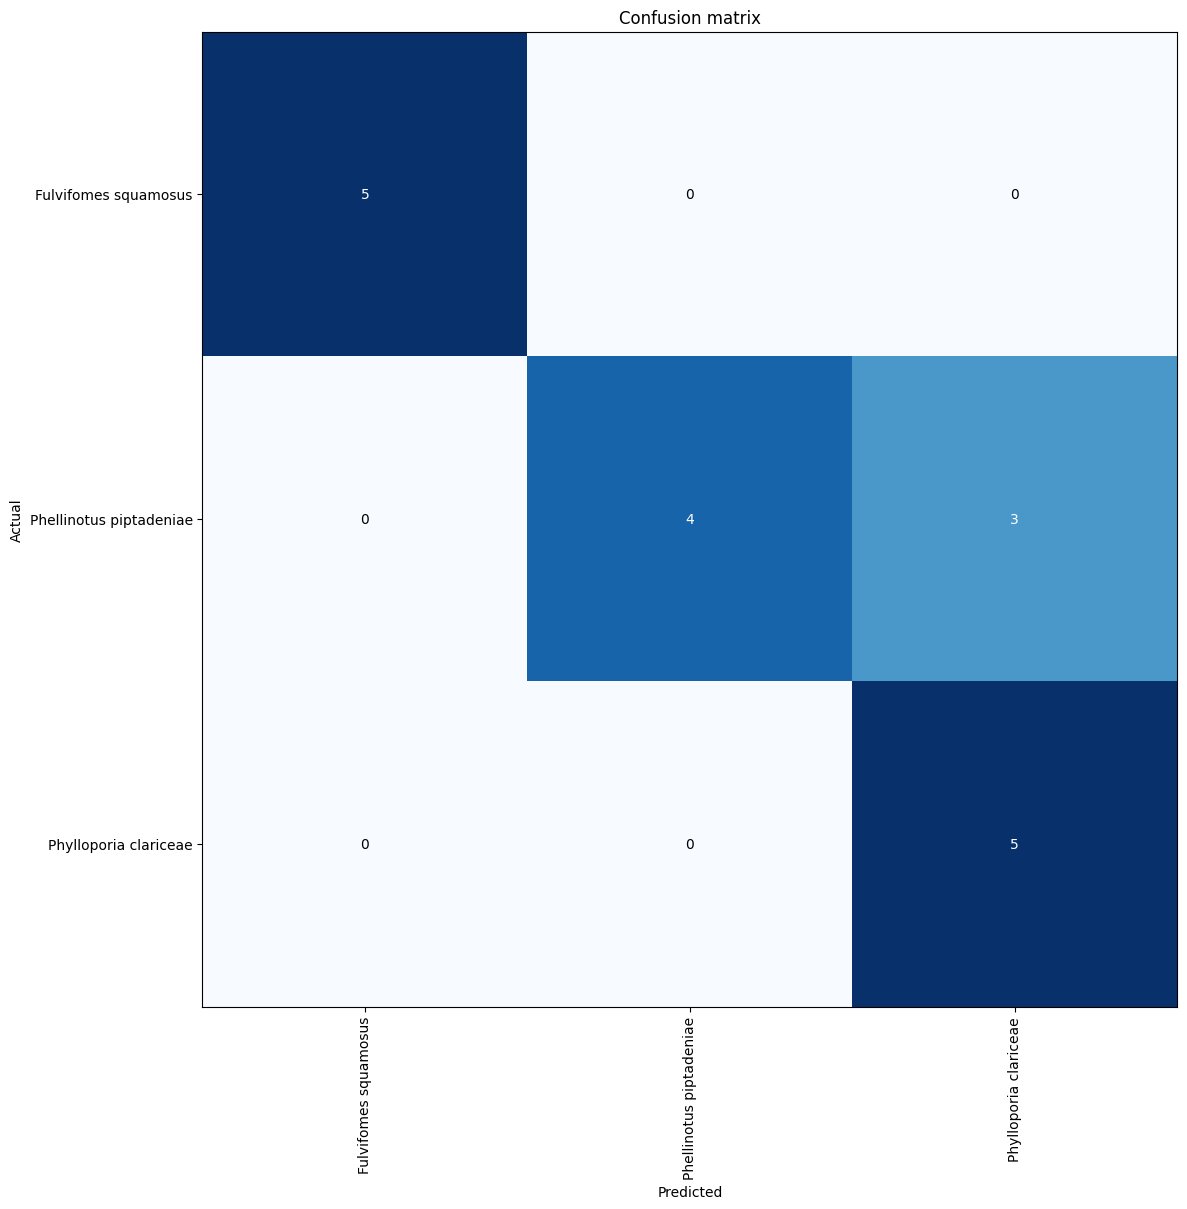

In [ ]:
# Evaluate model on validation set
interp = ClassificationInterpretation.from_learner(learn)

# Display best 5 and worst 5 results
interp.plot_top_losses(5, figsize=(20,20))
interp.plot_top_losses(5, largest=False, figsize=(20,20))

# Display heatmap of accuracy for each class
interp.plot_confusion_matrix(figsize=(12, 12), cmap='Blues')